# <font color="red">Conditions Prediction with Stacking</font>

# Library Import

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Classification models
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggle
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Variables

In [8]:
model_name_for_saving = "Stack"
target_name_for_saving = "Conditions"

# MinMax Scaler

## Best Features

In [9]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [10]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [11]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [12]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## Scaler

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [14]:
X_train

array([[0.81818182, 0.69565217, 1.        , ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.        , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.        , 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.34782609, 0.        , ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.65217391, 1.        , ..., 0.8155    , 0.542     ,
        0.07388643]], shape=(11692, 23))

In [15]:
X_test

array([[0.18181818, 0.52173913, 0.        , ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 1.        , 0.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.73913043, 1.        , ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.82608696, 0.        , ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.86956522, 0.        , ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.26086957, 0.        , ..., 0.4901    , 0.        ,
        0.99324467]], shape=(2924, 23))

## Model with Best Parameters

In [16]:
# Define base classifiers for stacking
base_classifiers = [
    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.1,
                                                    subsample=0.8,
                                                    n_iter_no_change=10,
                                                    n_estimators=300,
                                                    min_samples_split=15,
                                                    min_samples_leaf=2,
                                                    min_impurity_decrease=0.05,
                                                    max_features=0.8,
                                                    max_depth=5,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('RandomForest', RandomForestClassifier(n_estimators=200,
                                            min_samples_split=5,
                                            min_samples_leaf=1,
                                            min_impurity_decrease=0.0,
                                            max_samples=None,
                                            max_features=None,
                                            max_depth=None,
                                            bootstrap=True)),

    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('LightGBM', LGBMClassifier(subsample_for_bin=500000,
                                reg_lambda=0.1,
                                reg_alpha=0.0,
                                num_leaves=31,
                                n_estimators=100,
                                min_split_gain=0.2,
                                min_child_weight=0.01,
                                min_child_samples=100,
                                max_depth=7,
                                learning_rate=0.2,
                                feature_fraction=1.0,
                                bagging_freq=5,
                                bagging_fraction=0.9)),

    ('AdaBoost', AdaBoostClassifier(random_state=42)),

    ('LogisticRegression', LogisticRegression(C=10.0,
                                              max_iter=2000,
                                              penalty='l1',
                                              solver='saga')),

    ('SVM', SVC(tol=0.0001,
                shrinking=True,
                kernel='linear',
                gamma='scale',
                coef0=0.1,
                class_weight=None,
                C=100,
                probability=True)),

    ('KNN', KNeighborsClassifier(weights='distance',
                                 p=2,
                                 n_neighbors=3,
                                 metric='manhattan',
                                 leaf_size=30,
                                 algorithm='ball_tree'))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [17]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


## Training

In [18]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - GradientBoosting: GradientBoostingClassifier
  - RandomForest: RandomForestClassifier
  - DecisionTree: DecisionTreeClassifier
  - LightGBM: LGBMClassifier
  - AdaBoost: AdaBoostClassifier
  - LogisticRegression: LogisticRegression
  - SVM: SVC
  - KNN: KNeighborsClassifier
Meta-classifier: LogisticRegression

CPU times: total: 875 ms
Wall time: 1min 51s


,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


In [19]:
y_pred = training_model.predict(X_test)
y_pred

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [20]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [21]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9959
Precision: 0.9959
Recall:    0.9959
F1-Score:  0.9959


In [23]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.99      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           1.00      2924
             macro avg       1.00      0.99      1.00      2924
          weighted avg       1.00      1.00      1.00      2924



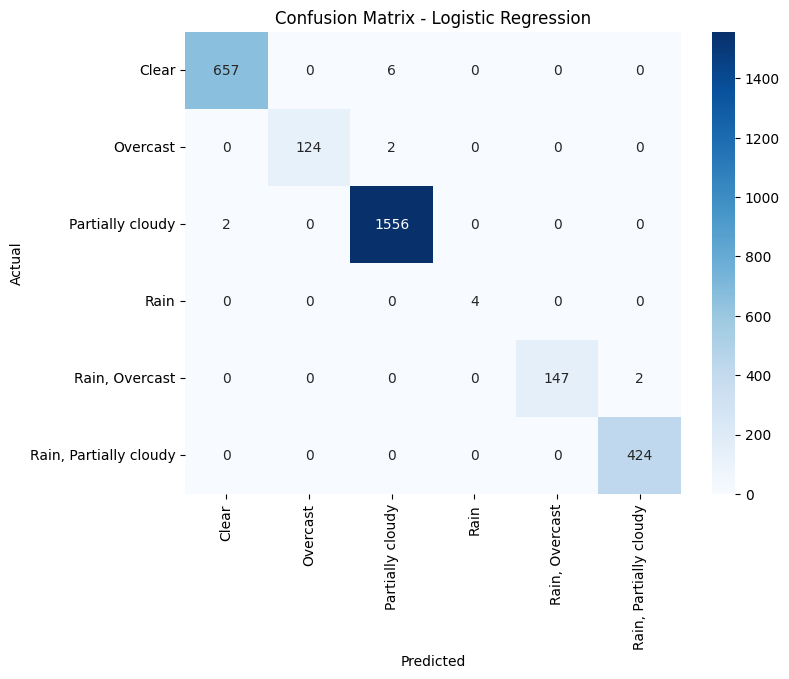

In [24]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [26]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9997
Overcast : 0.9982
Partially cloudy : 0.9994
Rain     : 1.0000
Rain, Overcast : 0.9986
Rain, Partially cloudy : 0.9995
Micro-avg : 0.9997


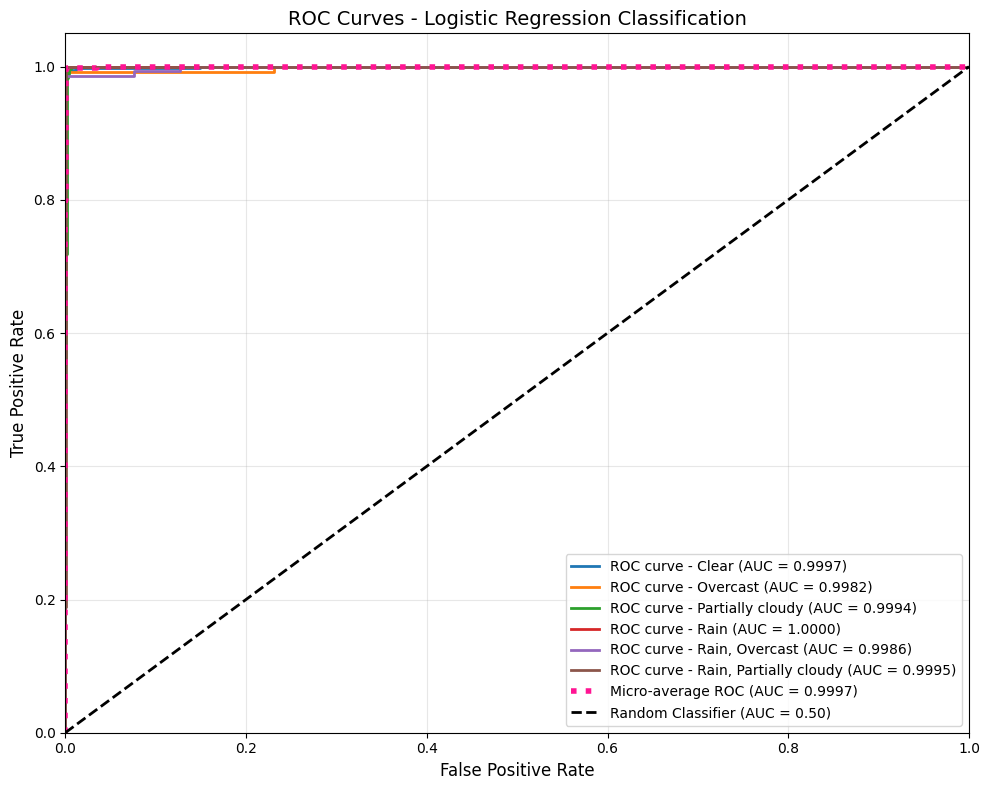

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9990
Micro-average          : 0.9997


In [30]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.995896, F1: 0.995891, AUC (micro-avg): 0.999702
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# Standard Scaler

## Best Features

In [31]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [32]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [33]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [34]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## Scaler

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [36]:
X_train

array([[ 1.34459066,  0.64443839,  2.54474033, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082,  1.22392493, -0.3929674 , ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -1.67350776, -0.3929674 , ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082, -1.67350776, -0.3929674 , ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 , -0.51453468, -0.3929674 , ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  0.49956676,  2.54474033, ...,  0.79539807,
         1.00886284, -0.43437432]], shape=(11692, 23))

In [37]:
X_test

array([[-0.8453494 ,  0.06495186, -0.3929674 , ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208,  1.65853984, -0.3929674 , ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.78931003,  2.54474033, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  1.0790533 , -0.3929674 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208,  1.22392493, -0.3929674 , ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082, -0.80427795, -0.3929674 , ..., -0.12954086,
        -0.74169989,  5.41145777]], shape=(2924, 23))

## Model with Best Parameters

In [38]:
# Define base classifiers for stacking
base_classifiers = [
    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.1,
                                                    subsample=0.8,
                                                    n_iter_no_change=10,
                                                    n_estimators=300,
                                                    min_samples_split=15,
                                                    min_samples_leaf=2,
                                                    min_impurity_decrease=0.05,
                                                    max_features=0.8,
                                                    max_depth=5,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('RandomForest', RandomForestClassifier(n_estimators=200,
                                             min_samples_split=5,
                                             min_samples_leaf=1,
                                             min_impurity_decrease=0.0,
                                             max_samples=None,
                                             max_features=None,
                                             max_depth=None,
                                             bootstrap=True)),

    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('LightGBM', LGBMClassifier(random_state=42,
                                verbose=0,
                                force_col_wise=True,
                                objective='multiclass')),
    
    ('AdaBoost', AdaBoostClassifier(random_state=42)),

    ('LogisticRegression', LogisticRegression(C=100.0,
                                              max_iter=2000,
                                              penalty='l1',
                                              solver='liblinear')),

    ('SVM', SVC(tol=0.0001,
                shrinking=True,
                kernel='linear',
                gamma='scale',
                coef0=0.1,
                class_weight=None,
                C=100,
                probability=True)),

    ('KNN', BaggingClassifier(estimator=KNeighborsClassifier(),
                              n_estimators=100,
                              random_state=42,
                              verbose=1,
                              n_jobs=-1,
                              bootstrap_features=True,
                              max_features=0.8))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [39]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


## Training

In [40]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - GradientBoosting: GradientBoostingClassifier
  - RandomForest: RandomForestClassifier
  - DecisionTree: DecisionTreeClassifier
  - LightGBM: LGBMClassifier
  - AdaBoost: AdaBoostClassifier
  - LogisticRegression: LogisticRegression
  - SVM: SVC
  - KNN: BaggingClassifier
Meta-classifier: LogisticRegression

CPU times: total: 1.22 s
Wall time: 2min 24s


,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


In [41]:
y_pred = training_model.predict(X_test)
y_pred

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished


array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [42]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [43]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [44]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9959
Precision: 0.9959
Recall:    0.9959
F1-Score:  0.9959


In [45]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.99      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           1.00      2924
             macro avg       1.00      0.99      1.00      2924
          weighted avg       1.00      1.00      1.00      2924



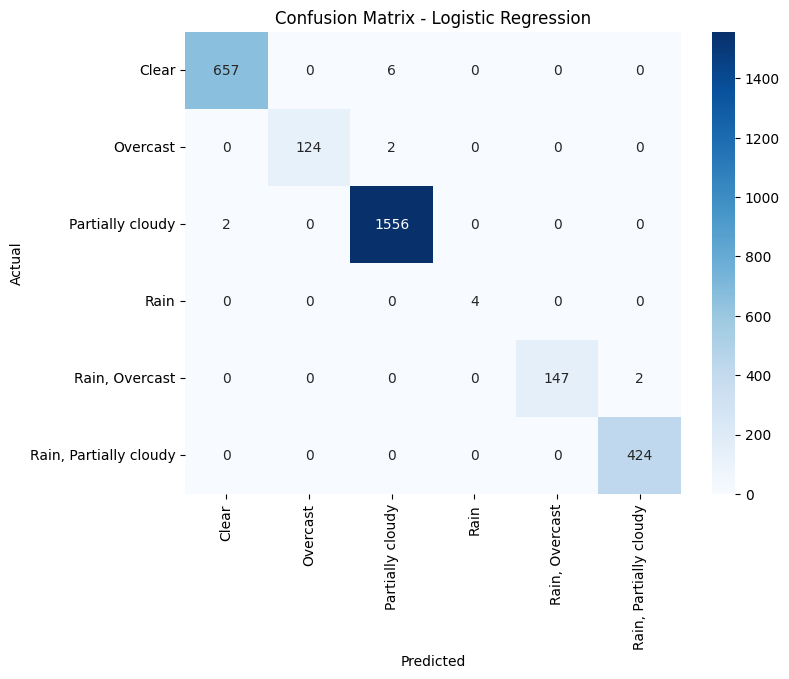

In [46]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.3s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished


In [48]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [49]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9966
Partially cloudy : 0.9997
Rain     : 1.0000
Rain, Overcast : 0.9990
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9997


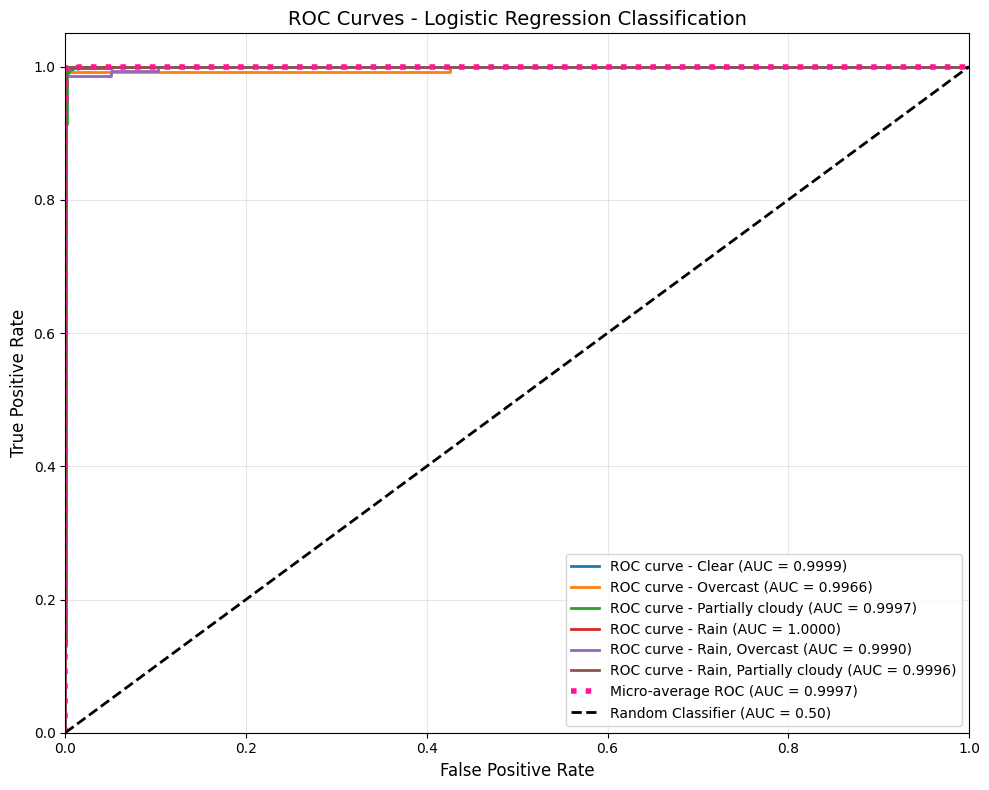

In [50]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [51]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9991
Micro-average          : 0.9997


In [52]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.995896, F1: 0.995891, AUC (micro-avg): 0.999724
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# Robust Scaler

## Best Features

In [53]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [54]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [55]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [56]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## Scaler

In [57]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [58]:
X_train

array([[ 1.00000000e+00,  3.33333333e-01,  1.00000000e+00, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01, -1.00000000e+00,  0.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01, -3.33333333e-01,  0.00000000e+00, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  2.50000000e-01,  1.00000000e+00, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]],
      shape=(11692, 23))

In [59]:
X_test

array([[-0.4       ,  0.        ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       ,  0.91666667,  0.        , ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.41666667,  1.        , ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.58333333,  0.        , ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       ,  0.66666667,  0.        , ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       , -0.5       ,  0.        , ..., -0.04159162,
         0.        , 33.75968992]], shape=(2924, 23))

## Model with Best Parameters

In [60]:
# Define base classifiers for stacking
base_classifiers = [
    ('GradientBoosting', GradientBoostingClassifier(validation_fraction=0.1,
                                                    subsample=0.8,
                                                    n_iter_no_change=10,
                                                    n_estimators=300,
                                                    min_samples_split=15,
                                                    min_samples_leaf=2,
                                                    min_impurity_decrease=0.05,
                                                    max_features=0.8,
                                                    max_depth=5,
                                                    loss='log_loss',
                                                    learning_rate=0.01,
                                                    ccp_alpha=0.0)),

    ('RandomForest', RandomForestClassifier(n_estimators=200,
                                             min_samples_split=5,
                                             min_samples_leaf=1,
                                             min_impurity_decrease=0.0,
                                             max_samples=None,
                                             max_features=None,
                                             max_depth=None,
                                             bootstrap=True)),

    ('DecisionTree', DecisionTreeClassifier(random_state=42)),

    ('LightGBM', LGBMClassifier(subsample_for_bin=300000,
                                reg_lambda=0.5,
                                reg_alpha=0.0,
                                num_leaves=50,
                                n_estimators=300,
                                min_split_gain=0.0,
                                min_child_weight=0.001,
                                min_child_samples=100,
                                max_depth=10,
                                learning_rate=0.2,
                                feature_fraction=1.0,
                                bagging_freq=0,
                                bagging_fraction=1.0)),

    ('AdaBoost', AdaBoostClassifier(random_state=42)),

    ('LogisticRegression', LogisticRegression(C=100.0,
                                              max_iter=2000,
                                              penalty='l1',
                                              solver='liblinear')),

    ('SVM', SVC(C=100,
                class_weight=None,
                coef0=0.1,
                gamma='scale',
                kernel='linear',
                shrinking=True,
                tol=0.0001,
                probability=True)),

    ('KNN', KNeighborsClassifier(weights='distance',
                                 p=2,
                                 n_neighbors=5,
                                 metric='manhattan',
                                 leaf_size=40,
                                 algorithm='ball_tree'))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=10000)

In [61]:
# Create Stacking Classifier
training_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

training_model

,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


## Training

In [62]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

training_model.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - GradientBoosting: GradientBoostingClassifier
  - RandomForest: RandomForestClassifier
  - DecisionTree: DecisionTreeClassifier
  - LightGBM: LGBMClassifier
  - AdaBoost: AdaBoostClassifier
  - LogisticRegression: LogisticRegression
  - SVM: SVC
  - KNN: KNeighborsClassifier
Meta-classifier: LogisticRegression

CPU times: total: 6.53 s
Wall time: 40min 9s


,estimators,"[('GradientBoosting', ...), ('RandomForest', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,1
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,300
,subsample,0.8


In [63]:
y_pred = training_model.predict(X_test)
y_pred

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [64]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [65]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [66]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9962
Precision: 0.9963
Recall:    0.9962
F1-Score:  0.9962


In [67]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.99      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           1.00      2924
             macro avg       1.00      0.99      1.00      2924
          weighted avg       1.00      1.00      1.00      2924



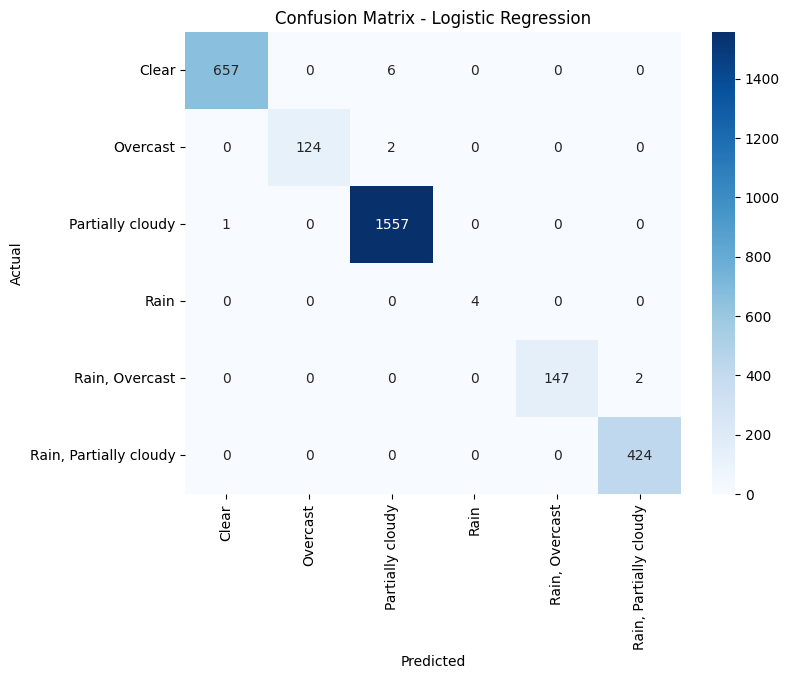

In [68]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [69]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [70]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [71]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9993
Partially cloudy : 0.9996
Rain     : 1.0000
Rain, Overcast : 0.9983
Rain, Partially cloudy : 0.9994
Micro-avg : 0.9998


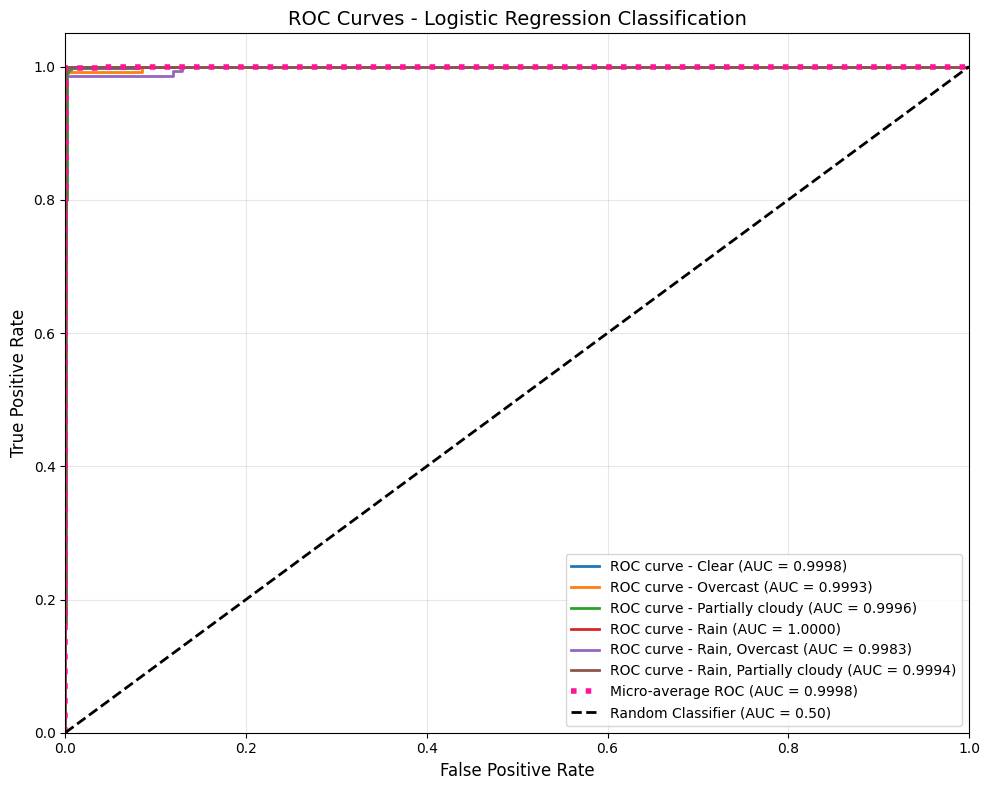

In [72]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9992
Micro-average          : 0.9998


In [74]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

# Convert parameters to JSON-serializable format
def make_json_serializable(params):
    """Convert complex objects to JSON-serializable strings"""
    serializable_params = {}
    for key, value in params.items():
        if hasattr(value, '__class__') and hasattr(value, 'get_params'):
            # For sklearn objects, store class name and parameters
            serializable_params[key] = {
                'class_name': value.__class__.__name__,
                'module': value.__class__.__module__,
                'params': str(value.get_params())
            }
        elif callable(value):
            # For functions, store string representation
            serializable_params[key] = str(value)
        elif isinstance(value, (list, tuple)) and len(value) > 0 and hasattr(value[0], '__class__'):
            # For lists of sklearn objects (like estimators in StackingClassifier)
            serializable_params[key] = [
                {
                    'name': item[0] if isinstance(item, tuple) else str(item),
                    'class_name': item[1].__class__.__name__ if isinstance(item, tuple) else item.__class__.__name__,
                    'params': str(item[1].get_params()) if isinstance(item, tuple) else str(item.get_params())
                } for item in value
            ]
        else:
            # For primitive types, keep as is
            serializable_params[key] = value
    return serializable_params

# Get serializable parameters
model_params = make_json_serializable(training_model.get_params())

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(model_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.996238, F1: 0.996233, AUC (micro-avg): 0.999830
   Features: 23
💾 Registry updated: Model_Training_History/History_Classification.csv


# All Performance

In [75]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
Model         Scaler     Target  Features Accuracy Precision   Recall F1-Score
Stack   RobustScaler Conditions        23 0.996238  0.996251 0.996238 0.996233
Stack   MinMaxScaler Conditions        23 0.995896  0.995906 0.995896 0.995891
Stack StandardScaler Conditions        23 0.995896  0.995906 0.995896 0.995891

📈 Total models shown: 3
🏆 Best F1-Score: 0.996233 (Stack + RobustScaler for Conditions)


# <center><font size="50" color="red">Thank You</font></center>